## Who's That Pokémon? A Machine Learning Exercise

The objective of this article is to create a dataset for training and testing multiple different Resnet based models to see how they perform in the task of differentiating starter pokémon from the first 5 generations

To prepare the models we'll take the following steps:

1. Use DuckDuckGo to search for pictures of each of the pokémon in certain variations
1. Fine-Tune the pre built neural networks
1. Compare their results by analyzing both the loss and the confusion matrix
1. Test it with each of the pokémon we selected

## Step 1: Downloading the necessary images


Right here we'll install the needed dependencies such as DuckDuckGo and fastAI

In [1]:
!pip install -Uqq duckduckgo_search
from fastai.vision.widgets import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.9 MB/s eta 0:00:00


In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

Download examples

Here we'll download some example images from official artwork of each pokémon

/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


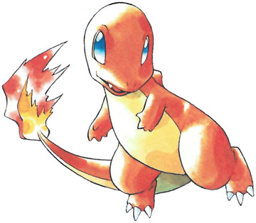

In [3]:
from fastdownload import download_url
download_url(search_images('charmander oficial artwork', max_images=1)[0], 'Charmander.jpg', show_progress=False)

from fastai.vision.all import *
im = Image.open('Charmander.jpg')
im.to_thumb(256,256)

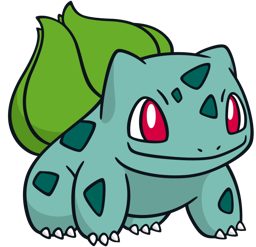

In [4]:
download_url(search_images('Bulbasaur oficial artwork', max_images=1)[0], 'Bulbasaur.jpg', show_progress=False)
Image.open('Bulbasaur.jpg').to_thumb(256,256)

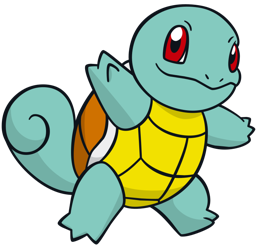

In [5]:
download_url(search_images('Squirtle oficial artwork', max_images=1)[0], 'Squirtle.jpg', show_progress=False)
Image.open('Squirtle.jpg').to_thumb(256,256)

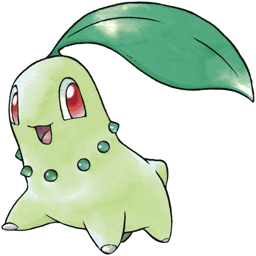

In [6]:
download_url(search_images('Chikorita oficial artwork', max_images=1)[0], 'Chikorita.jpg', show_progress=False)
Image.open('Chikorita.jpg').to_thumb(256,256)

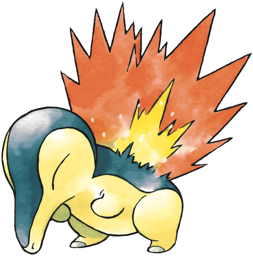

In [7]:
download_url(search_images('Cyndaquil oficial artwork', max_images=1)[0], 'Cyndaquil.jpg', show_progress=False)
Image.open('Cyndaquil.jpg').to_thumb(256,256)

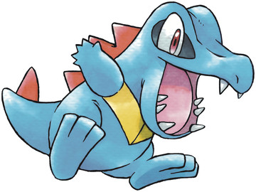

In [8]:
download_url(search_images('Totodile oficial artwork', max_images=1)[0], 'Totodile.jpg', show_progress=False)
Image.open('Totodile.jpg').to_thumb(256,256)

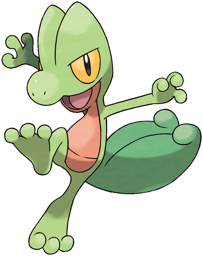

In [9]:
download_url(search_images('Treecko oficial artwork', max_images=1)[0], 'Treecko.jpg', show_progress=False)
Image.open('Treecko.jpg').to_thumb(256,256)

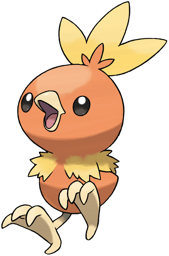

In [10]:
download_url(search_images('Torchic oficial artwork', max_images=1)[0], 'Torchic.jpg', show_progress=False)
Image.open('Torchic.jpg').to_thumb(256,256)

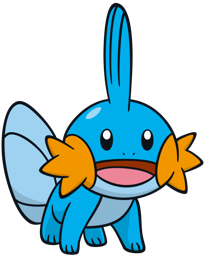

In [11]:
download_url(search_images('Mudkip oficial artwork', max_images=1)[0], 'Mudkip.jpg', show_progress=False)
Image.open('Mudkip.jpg').to_thumb(256,256)

### Downloading search result images for Dataset

Here we set the list of the pokémon names we'll search online for pictures as well as define a couple of other parameters for the pictures, such as pictures of them as plushies or their original game sprites.

In [13]:
searches = 'Charmander','Squirtle','Bulbasaur','Chikorita','Cyndaquil','Totodile','Torchic','Mudkip','Treecko'
path = Path('Whos_That_Pokemon')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} plush'))
    sleep(1)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sprite'))
    sleep(1)
    download_images(dest, urls=search_images(f'{o} shiny sprite'))
    sleep(2)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes sh

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll verify and remove them:

In [14]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

295

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

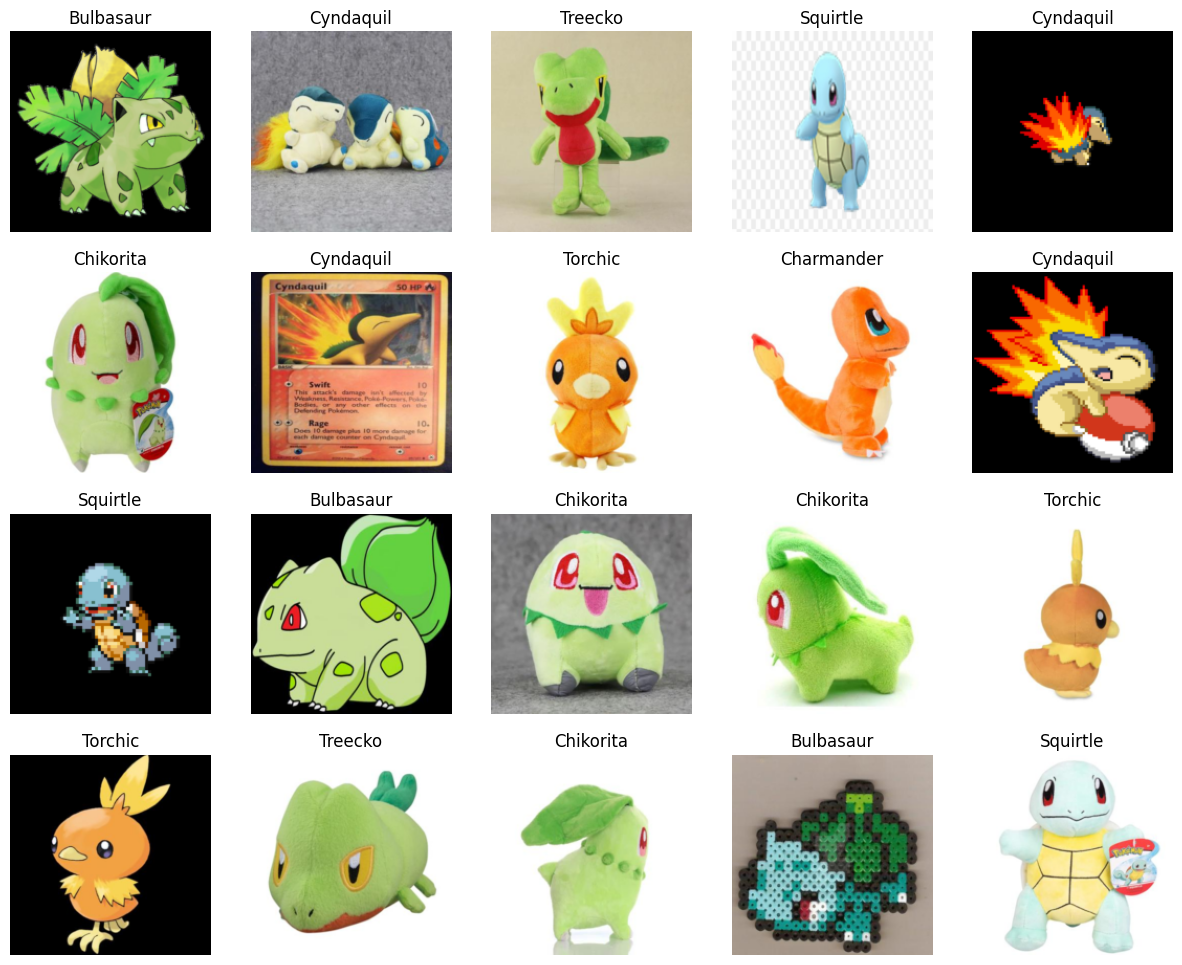

In [15]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=20)

## Step 3: Testing models

Now that we have our dataset and datablock, we'll load the different Resnet models and run each of them with 4 epochs of fine tuning to compare their results.

#### Resnet-18

In [32]:
learn_18 = vision_learner(dls, resnet18, metrics=error_rate)
learn_18.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.426170,0.349459,0.105968,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.305293,0.189348,0.047503,00:24
1,0.142571,0.170207,0.038977,00:24
2,0.077213,0.149935,0.042631,00:23
3,0.041375,0.150184,0.041413,00:23


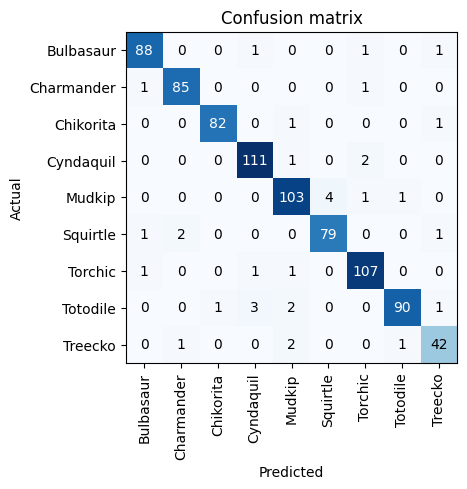

In [33]:
interp = ClassificationInterpretation.from_learner(learn_18)
interp.plot_confusion_matrix()

#### Resnet-50

In [34]:
learn_50 = vision_learner(dls, resnet50, metrics=error_rate)
learn_50.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.982354,0.384689,0.099878,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.219830,0.183808,0.048721,00:31
1,0.127230,0.201719,0.049939,00:32
2,0.066784,0.152498,0.032887,00:31
3,0.031606,0.144139,0.030451,00:32


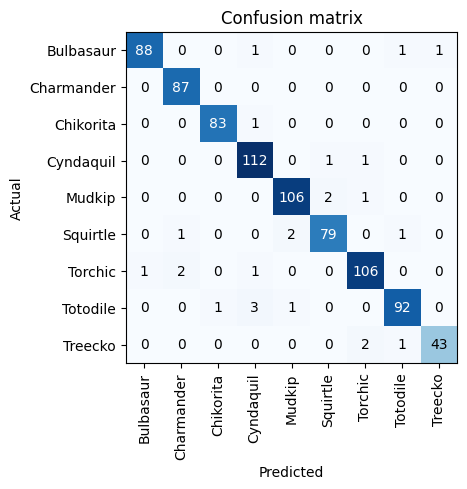

In [35]:
interp = ClassificationInterpretation.from_learner(learn_50)
interp.plot_confusion_matrix()

#### Resnet-164

In [36]:
learn_164 = vision_learner(dls, resnet50, metrics=error_rate)
learn_164.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.020707,0.384882,0.101096,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.219550,0.172796,0.045067,00:31
1,0.143165,0.134992,0.037759,00:30
2,0.066205,0.141081,0.037759,00:31
3,0.031232,0.115221,0.032887,00:32


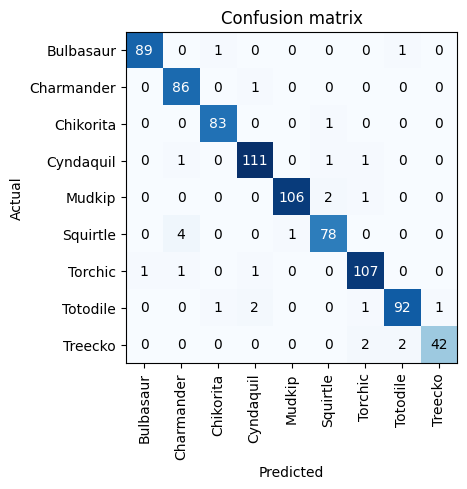

In [37]:
interp = ClassificationInterpretation.from_learner(learn_164)
interp.plot_confusion_matrix()

## Step 4: Using the model

Let's see some example tests of what are model thinks and the actual result:

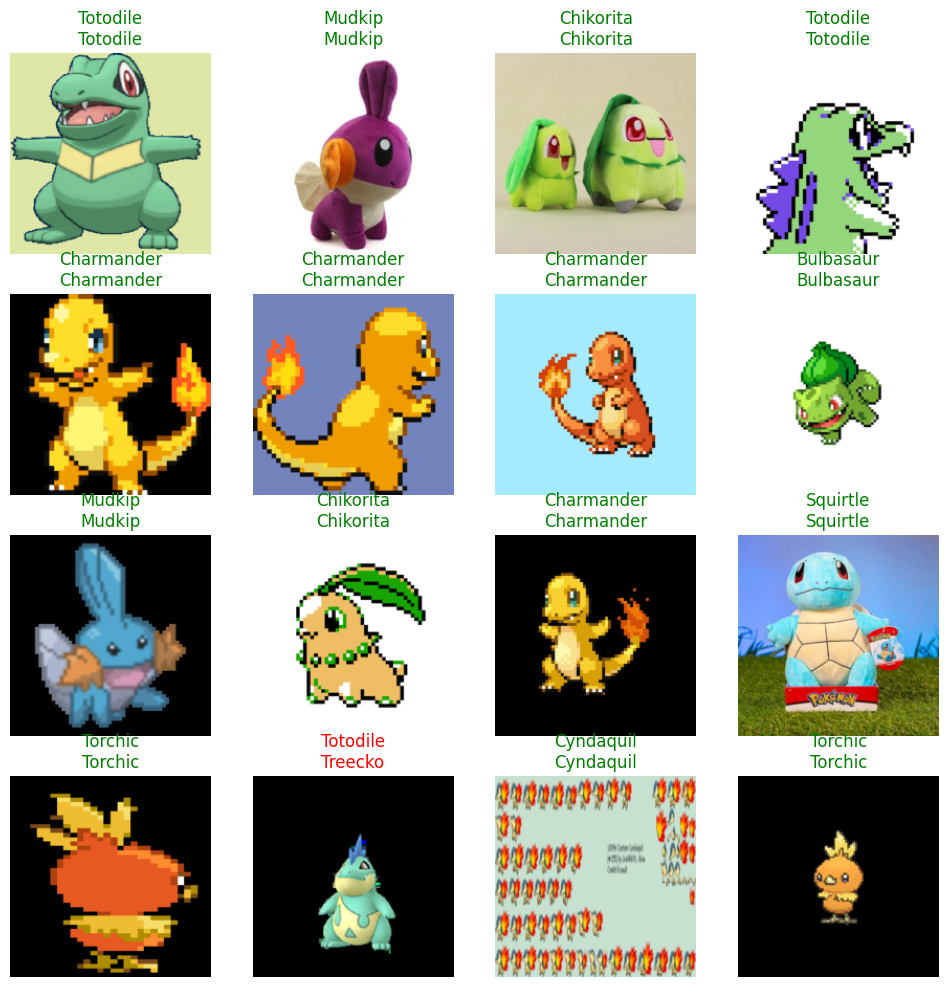

In [43]:
learn_164.show_results(max_n=16)

### Cleaning Up
Here we have the opportunity to improve our dataset by removing images that don't match our topic or relabel images that may have been mislabeled.

### Testing
Now we'll train our model on the previous example images to check if it's getting the results correctly.

This is a: Bulbasaur.
Probability it's a Bulbasaur: 99.72%


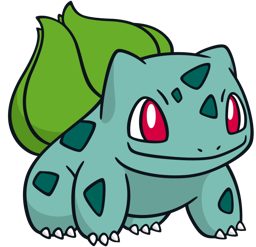

In [44]:
item="Bulbasaur.jpg"
is_bulb,_,probs = learn_18.predict(PILImage.create(item))
print(f"This is a: {is_bulb}.")
print(f"Probability it's a {is_bulb}: {probs.sort()[0][-1]*100:.2f}%")
im = Image.open(item)
im.to_thumb(256,256)

This is a: Chikorita.
Probability it's a Chikorita: 100.00%


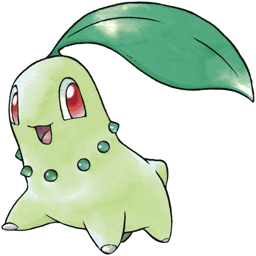

In [45]:
item="Chikorita.jpg"
is_bulb,_,probs = learn_18.predict(PILImage.create(item))
print(f"This is a: {is_bulb}.")
print(f"Probability it's a {is_bulb}: {probs.sort()[0][-1]*100:.2f}%")
im = Image.open(item)
im.to_thumb(256,256)

This is a: Treecko.
Probability it's a Treecko: 99.84%


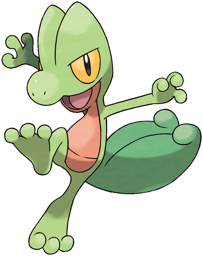

In [46]:
item="Treecko.jpg"
is_bulb,_,probs = learn_18.predict(PILImage.create(item))
print(f"This is a: {is_bulb}.")
print(f"Probability it's a {is_bulb}: {probs.sort()[0][-1]*100:.2f}%")
im = Image.open(item)
im.to_thumb(256,256)

In [42]:
learn_18.export("pokemodel.pkl")

# Give it a shot!
The model related to this article has been deployed on the following link where using gradio it's possible not only to check the tests previously shown here, but also test it with your own images. Just click [here!](https://huggingface.co/spaces/AlGouvea/ML_Entrega_2)
